In [1]:
from tensorflow.keras.applications.vgg19 import preprocess_input,decode_predictions
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import models
#conv5/conv5_2 unit 148
#VGG 19
#Data from https://github.com/fastai/imagenette?tab=readme-ov-file
vgg = tf.keras.applications.VGG19()
#https://www.kaggle.com/datasets/deeptrial/miniimagenet


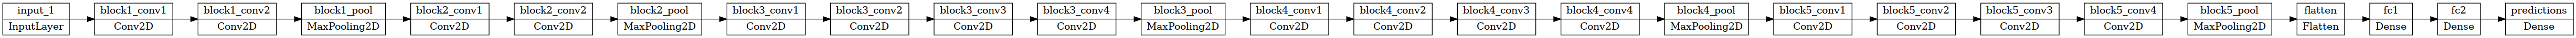

In [2]:
tf.keras.utils.plot_model(vgg,rankdir='LR')

In [3]:
IMG_SHAPE = (224,224)

# Image Processing

In [4]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')

In [42]:
def clean_image_directory(filepath): #Will remove greyscale images from directory
    data = {}
    for subfolder in os.listdir(filepath):
        data[subfolder] = 0
        subfolder_path = os.path.join(filepath,subfolder)
        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path,img_name)
            img = Image.open(img_path)
            if img.mode == "L" or np.array(img).shape[-1] > 3:
                print(f'Removed {img_path}')
                os.remove(img_path)
            else:
                data[subfolder] = data[subfolder] + 1
    # print(data)
    # print(min(data.values()))

clean_image_directory('./ImageNet-Mini/images')

Removed ./ImageNet-Mini/images/n13133613/ILSVRC2012_val_00019877.JPEG


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


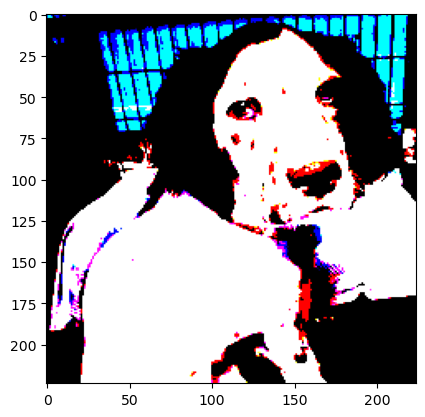

In [43]:
def load_image_for_processing(filepath,prep_for_vgg=True):
    img = Image.open(filepath)
    img = img.resize(size=IMG_SHAPE) #reisze to model's input expectation (can change model input and this still works)
    img = np.array(img)
    if prep_for_vgg:
        img = preprocess_input(img)
    return img



plt.imshow(load_image_for_processing('/mnt/c/Users/alexs/ML/Proj3/ML_Conv_Visuals/imagenette2-320/train/n02102040/ILSVRC2012_val_00016833.JPEG',prep_for_vgg=True))

In [44]:
import json
import pprint
pp = pprint.PrettyPrinter(indent=3)
def get_name_mapper(filepath):
    with open(filepath,'r') as fp:
        dct = json.load(fp)
        # pp.pprint(dct)
        _dct = {}
        for val in dct.values():
            _dct[val[0]] = val[1]
    return _dct
            

In [45]:
def get_example_images(directory_path,num_classes=2,num_examples_per_class=2,prep_for_vgg=False,name_mapper_filepath='ImageNet-Mini/imagenet_class_index.json'):
    possible_classes = os.listdir(directory_path)
    num_classes = min(len(possible_classes),num_classes)
    chosen_classes = np.random.choice(possible_classes,size=num_classes,replace=False)
    print(f'Classes Chosen: {chosen_classes}')
    data = {}
    mapper = get_name_mapper(name_mapper_filepath)

    for cls in chosen_classes:
        mapped_class = mapper.get(cls,None)
        if mapped_class is None:
            raise RuntimeError(f'Could not look up class {cls}')
        data[mapped_class] = []
        cls_pth = os.path.join(directory_path,cls)
        images = os.listdir(cls_pth)
        # print(len(images))
        images = np.random.choice(images,size=min(num_examples_per_class,len(images)),replace=False)
        for img in images:
            img_pth = os.path.join(cls_pth,img)
            the_img = load_image_for_processing(img_pth,prep_for_vgg=prep_for_vgg)

            data[mapped_class].append(the_img)
            # print(data[-1].shape)
    # print(data)
    return data


result = get_example_images('ImageNet-Mini/images',num_classes=10)


Classes Chosen: ['n02028035' 'n01644900' 'n04118776' 'n02102040' 'n04467665' 'n02493793'
 'n03026506' 'n02125311' 'n02088094' 'n02950826']


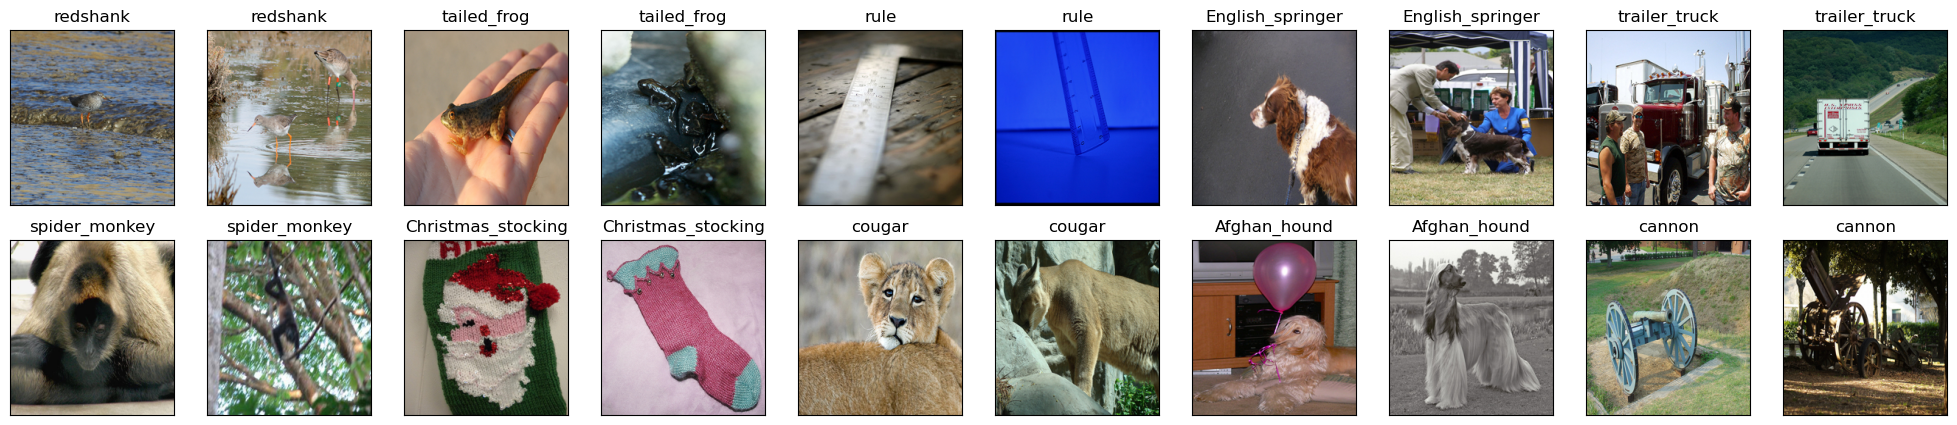

In [46]:
def display_images(imgs_dct,figsize=(25,5)):
    num_rows = max([len(list(imgs_dct.values())[i]) for i in range(len(imgs_dct))])

    num_cols = len(imgs_dct)

    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    titles = np.array([[key] * len(val) for key,val in imgs_dct.items()]).flatten()
    for ax,img,title in zip(axs.flatten(),np.array(list(imgs_dct.values())).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3),titles):
        ax.imshow(img,aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(title)
    # plt.subplots_adjust(wspace=0, hspace=0)
    
display_images(result)

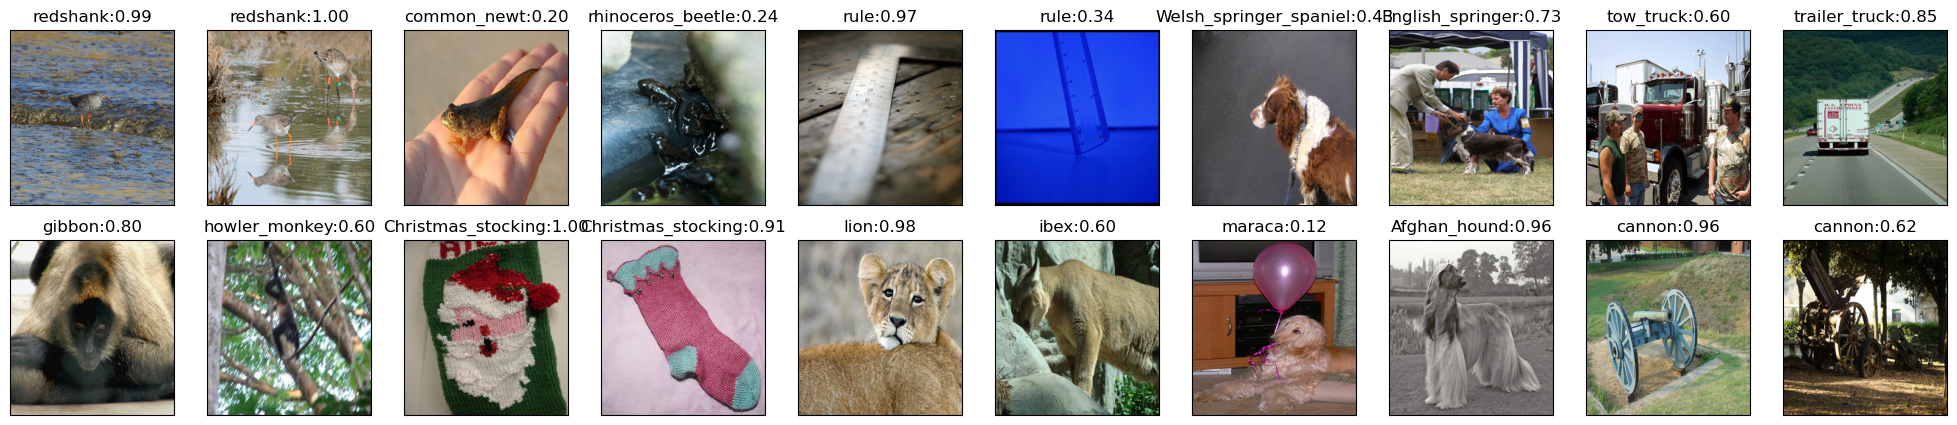

In [47]:
def display_images_with_prediction(imgs_dct,figsize=(25,5)):
    num_rows = max([len(list(imgs_dct.values())[i]) for i in range(len(imgs_dct))])

    num_cols = len(imgs_dct)
    imgs = np.array(list(imgs_dct.values())).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3)
    ready_images = np.array([preprocess_input(x) for x in imgs])
    # return ready_images
    preds = vgg(ready_images).numpy()
    preds = decode_predictions(preds)
    num_cols = int(np.ceil(float(len(imgs)/num_rows)))
    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    for ax,img,pred in zip(axs.flatten(),imgs,preds):
        ttl = pred[0][1]
        prob = round(pred[0][2],ndigits=2)
        
        ax.imshow(img,aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'{ttl}:{prob:0.2f}')
    # plt.subplots_adjust(wspace=0.2, hspace=3)

tmp = display_images_with_prediction(result)

In [48]:
example_images_dict = get_example_images(directory_path='ImageNet-Mini/images',num_classes=np.inf)

Classes Chosen: ['n02132136' 'n02692877' 'n07747607' 'n04125021' 'n02108422' 'n09229709'
 'n03983396' 'n01872401' 'n02492660' 'n02110806' 'n03110669' 'n09246464'
 'n02504013' 'n02123045' 'n04074963' 'n03891251' 'n01770081' 'n03538406'
 'n04228054' 'n02099429' 'n02102480' 'n04599235' 'n03452741' 'n04037443'
 'n02489166' 'n02129165' 'n01983481' 'n04311004' 'n02111889' 'n04254120'
 'n03598930' 'n02493509' 'n02277742' 'n03417042' 'n04209239' 'n01744401'
 'n02129604' 'n04254777' 'n03063689' 'n01560419' 'n03388183' 'n02999410'
 'n02028035' 'n03085013' 'n01775062' 'n03854065' 'n02017213' 'n01582220'
 'n02124075' 'n01753488' 'n07717556' 'n02321529' 'n02112018' 'n02009229'
 'n02096437' 'n03459775' 'n03761084' 'n04238763' 'n02486261' 'n02219486'
 'n03255030' 'n02101388' 'n02817516' 'n03903868' 'n01689811' 'n04485082'
 'n03444034' 'n03000247' 'n07714571' 'n02445715' 'n04127249' 'n02865351'
 'n04579432' 'n03759954' 'n04008634' 'n01990800' 'n01697457' 'n02317335'
 'n02090721' 'n02892201' 'n02058221

# Modeling

## Part 2

In [12]:
# model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None)

# # set VGG to be frozen
# for layer in model.layers:
#     layer.trainable = False

# # Selecting a layer and channel to visualize
# layer_name = 'block5_conv2'
# filter_index = 0

# # Isolate the output of interest and create new model
# layer_output = model.get_layer(layer_name).output
# new_model = models.Model(inputs=model.input, outputs=layer_output)
# # now "new_model" has the output we desire to maximize

# # create a variable that we can access and update in computation graph
# I = tf.Variable(np.zeros((1, 150, 150, 3),dtype='double'), name='image_var', dtype = 'float64')

# # now use gradient tape to get the gradients (watching only the variable v)
# with tf.GradientTape(watch_accessed_variables=False) as tape:
#     tape.watch(I) # watch
#     model_vals = new_model(preprocess_input(I)) # get output
#     filter_output_to_maximize = tf.reduce_mean(model_vals[:, :, :, filter_index]) # define what we want to maximize
    
# grad_fn = tape.gradient(filter_output_to_maximize, I) # get gradients that influence loss w.r.t. v
# grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm (better stability)

# # now show the gradient, same size as input image
# plt.imshow(prepare_image_for_display( grad_fn.numpy(), norm_type='std'))
# plt.title('The gradient of filter w.r.t I, $ \sum\partial f_n(I)_{i,j} $ ')
# plt.show()

In [49]:
CONV_BLOCK_NAME = 'block5_conv2'
CONV_BLOCK_IDX = 63

In [168]:
def generate_pattern(layer_name, filter_index, size=150,epochs=40,model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None)):
    
    # set VGG to be frozen
    for layer in model.layers:
        layer.trainable = False
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # input_img_data = np.zeros(shape=(1,size,size,3))
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(epochs):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(filter_output, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

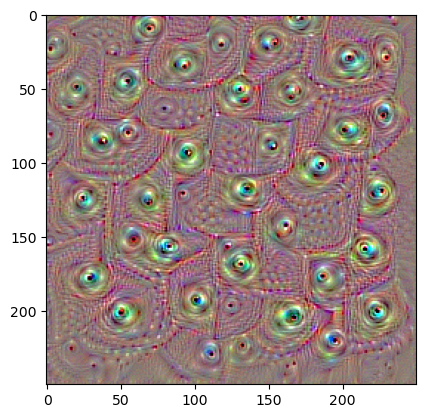

In [169]:
plt.imshow(generate_pattern(CONV_BLOCK_NAME, CONV_BLOCK_IDX, size=250,epochs=40))
plt.show()

In [58]:
def find_max_excitory_images(imgs_dct,layer_name,layer_idx,filter_func=np.average,model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None)):
    for layer in model.layers:
        layer.trainable = False
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)

    # imgs = np.array(list(imgs_dct.values())).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3)
    imgs = []
    for arr in imgs_dct.values():
        for i in arr:
            imgs.append(i)
    imgs = np.array(imgs).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3)
    ready_images = np.array([preprocess_input(x) for x in imgs])
    print(ready_images.shape)
    results = new_model.predict(ready_images)

    excite_vals = []
    for res,img in zip(results,imgs):
        excite_vals.append((filter_func(res[:,:,layer_idx]),img))
    
    excite_vals = sorted(excite_vals,key=lambda x: x[0],reverse=True)
    return excite_vals

img_excitations = find_max_excitory_images(example_images_dict,CONV_BLOCK_NAME,CONV_BLOCK_IDX,filter_func=np.average)

(1987, 224, 224, 3)
63/63 [==============================] - 3s 35ms/step


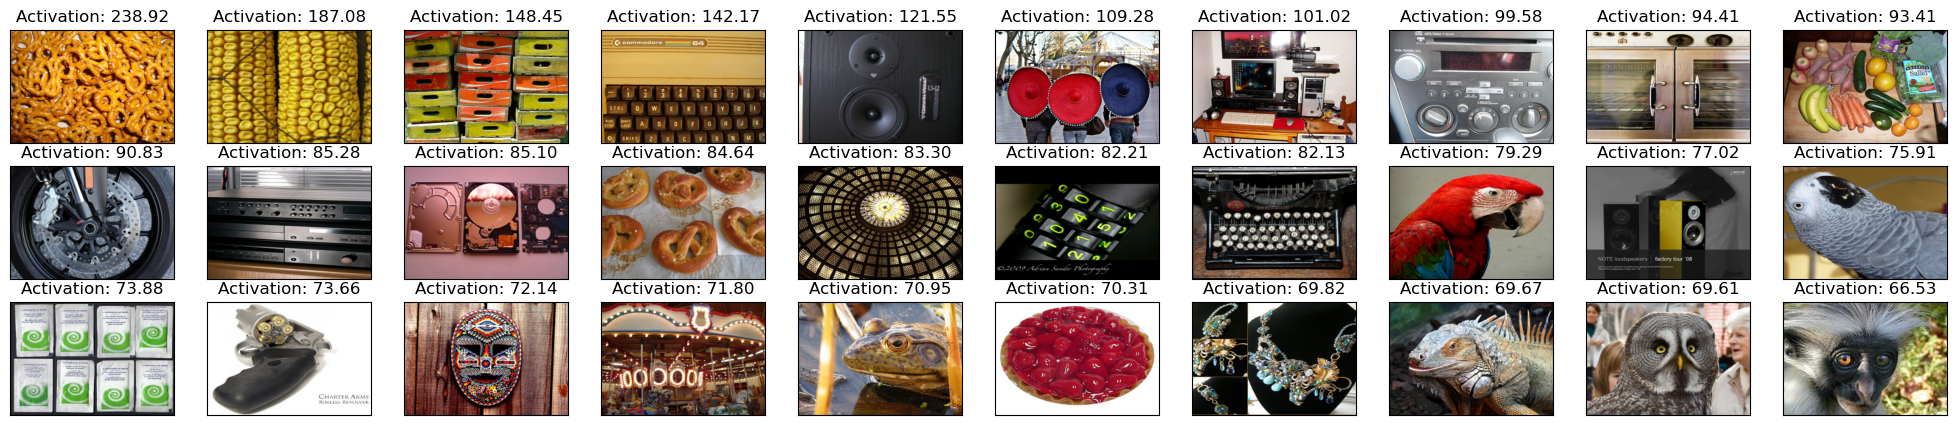

In [64]:
def plot_max_excitory_images(imgs_array,num_to_plot=10,num_rows=2,figsize=(25,5)):
    num_cols = int(np.ceil(num_to_plot / num_rows))
    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    subset = imgs_array[:num_to_plot]
    for ax,val in zip(axs.flatten(),subset):
        ax.imshow(val[1],aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'Activation: {val[0]:0.2f}')
    
    return subset
top_imgs = plot_max_excitory_images(img_excitations,num_to_plot=30,num_rows=3)

Circle Detector

## Part 3
[4 Points] Analyze each channel of the multi-channel filter to better understand how this might form a circuit (i.e., the weights of the filter). That is, visualize the convolutional filter (one channel at a time) between the input activations and the current activation to understand which inputs make up a circuit. You should avoid filter channels that are mostly "zero" coefficients. These are not influential for the circuit. One method of doing this is given below:
Extract the filter coefficients for each input activation to that multi-channel filter. Note: If the multi-channel filter is 5x5 with an input channel size of 64, then this extraction will result in 64 different single channel filters, each of size 5x5. 
Keep the top ten sets of inputs with the "strongest" weights. For now, you can use the L2 norm of each input filter as a measure of strength. Visualize these top ten filters. 
For these ten strongest input filters, categorize each as "mostly inhibitory" or "mostly excitatory." That is, does each filter consist of mostly negative or mostly positive coefficients?  

In [132]:
def get_top_strongest_weights(layer_name,layer_idx,top_n=10,model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None),evaluate_function=np.linalg.norm):
    layer = model.get_layer(layer_name)
    filter_weights = layer.get_weights()[0]
    filter_weights = filter_weights[:,:,:,layer_idx]
    result = []
    for idx in range(filter_weights.shape[-1]):
        result.append((idx,evaluate_function(filter_weights[:,:,idx])))
    
    return sorted(result,key=lambda x: x[1],reverse=True)[:top_n]
    # return filter_weights

top_filters = get_top_strongest_weights(CONV_BLOCK_NAME,CONV_BLOCK_IDX,top_n=10)

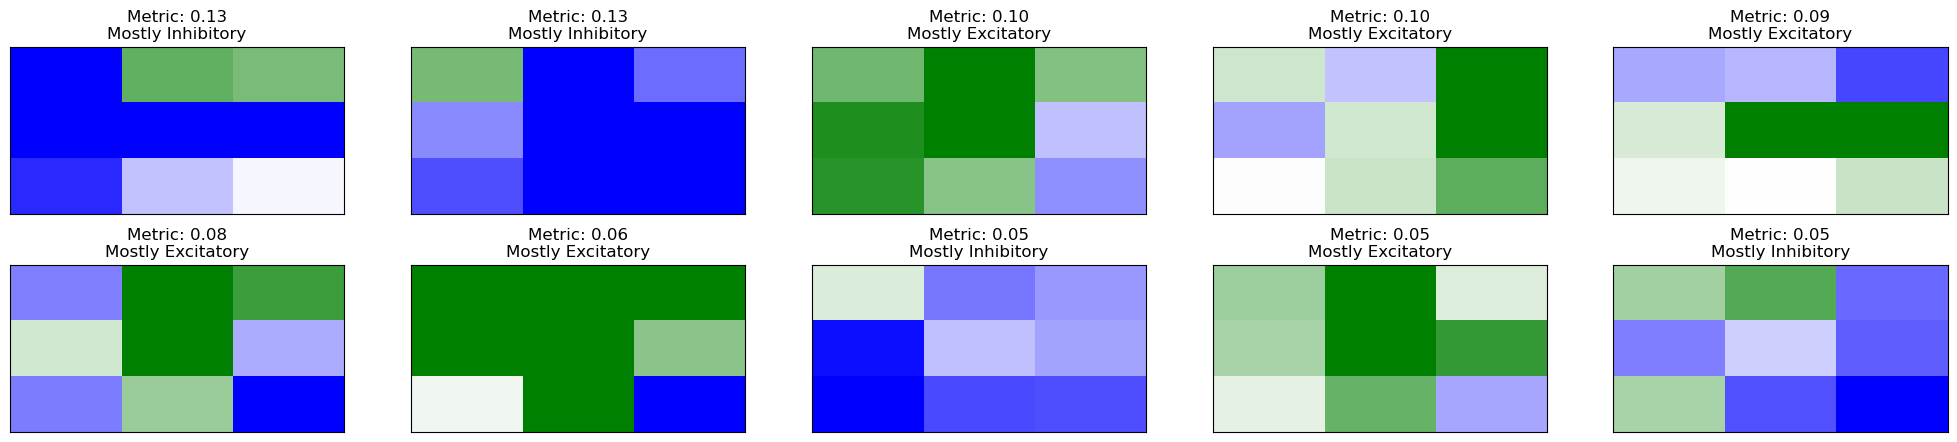

In [142]:
import matplotlib.colors as colors
def display_top_filters(layer_name,layer_idx,top_filters,model=tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None),num_rows=2,figsize=(25,5)):
    num_cols = int(np.ceil(len(top_filters) / num_rows))
    layer = model.get_layer(layer_name)
    filter_weights = layer.get_weights()[0]
    filter_weights = filter_weights[:,:,:,layer_idx]
    fig,axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    norm=plt.Normalize(-0.007,0.007)
    cmap = colors.LinearSegmentedColormap.from_list("", ["blue",'white',"green"])
    for i,ax in enumerate(axs.flatten()):
        # filt = prepare_image_for_display(filter_weights[:,:,i])
        filt = filter_weights[:,:,i]
        # print(filt)
        ax.imshow(filt,aspect='auto',cmap=cmap,norm=norm)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'Metric: {top_filters[i][1]:0.2f}\nMostly {"Inhibitory" if np.average(filt) < 0 else "Excitatory"}')
    
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
display_top_filters(CONV_BLOCK_NAME,CONV_BLOCK_IDX,top_filters)

In [143]:
top_filters

[(6, 0.12797067),
 (168, 0.1262323),
 (129, 0.10249913),
 (251, 0.10240816),
 (196, 0.09096281),
 (297, 0.075551964),
 (174, 0.055974964),
 (420, 0.05409162),
 (360, 0.052835487),
 (34, 0.051753003)]

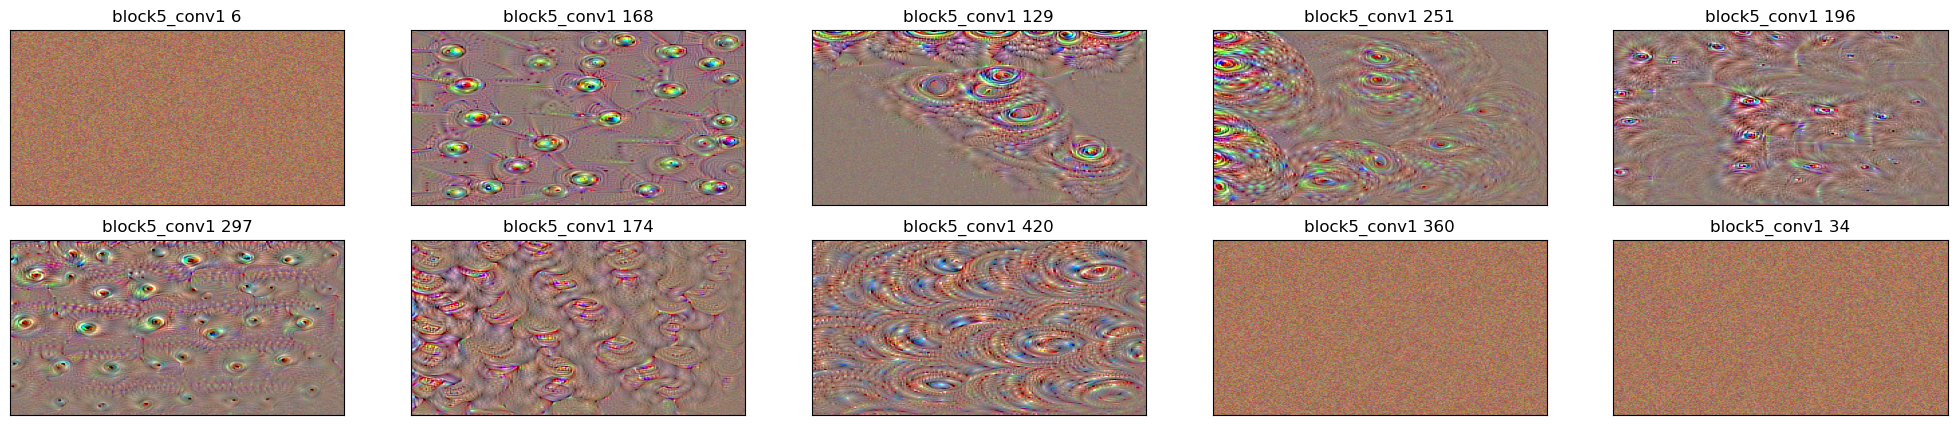

In [172]:

def plot_top_filters_excited_input(layer_name,top_filters,model=tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None),num_rows=2,figsize=(25,5),size=150,epochs=40):
    num_cols = int(np.ceil(len(top_filters) / num_rows))
    fig,axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    for ax,filter_tuple in zip(axs.flatten(),top_filters):
        ax.imshow(generate_pattern(layer_name,filter_tuple[0],size=size,epochs=epochs,model=model),aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'{layer_name} {filter_tuple[0]}')

plot_top_filters_excited_input('block5_conv1',top_filters,epochs=40,size=250)